In [1]:
from markov_chain import SimpleSymmetricRandomWalk, get_samples_from_mean_estimator_for_inverse_square, inverse_square
from bootstrap import rbb_parallel_apply_async, regeneration_based_bootstrap_parallel_apply_async
from utils import get_bootstrap_ci_mean, get_iid_ci_mean,get_coverage_probability, get_normalized_mean_statistic
from experiments import get_coverage_probability_ssrw
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Prepare style for the plots
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
# Random seed for reproducibility
random_seed = 2024
np.random.seed(random_seed)

In [4]:
# Variables
max_n_steps = 10**3  # Number of steps to simulate on each chain
n_bootstraps = 10**3  # Number of bootstraps to perform

n_reps = 10**3  # Number of times we will repeat the experiment (in order to obtain the coverage probability)

true_mean = (np.pi**2)/3

In [5]:
simple_symmetric_random_walk = SimpleSymmetricRandomWalk(step_n=max_n_steps, name="simple_rw", random_seed=random_seed)

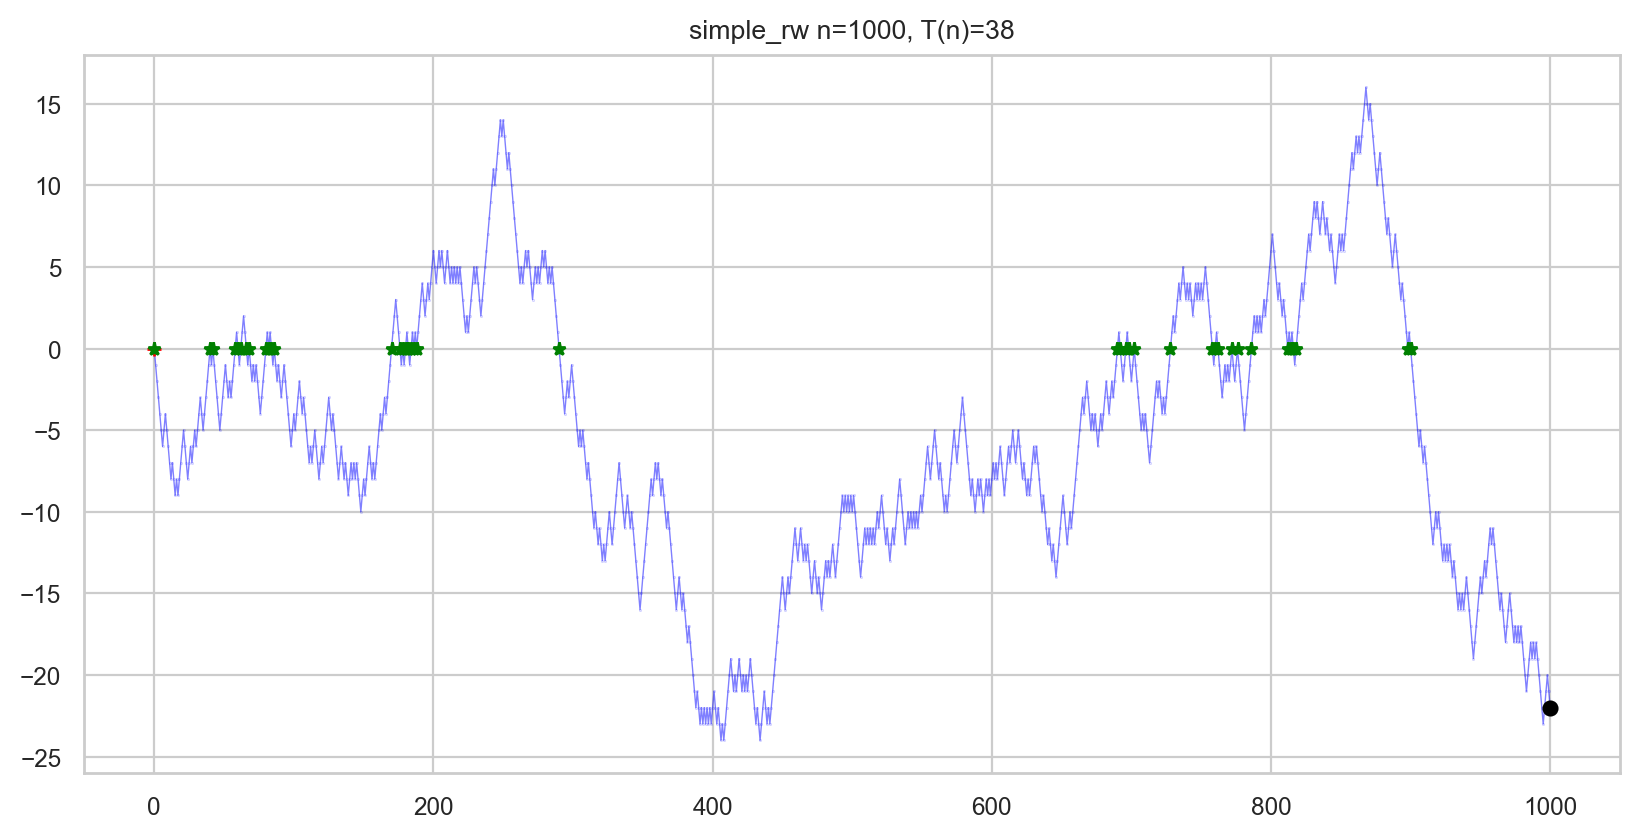

In [6]:
simple_symmetric_random_walk.plot_simulation(save=False, state=0)

In [7]:
regeneration_block_sizes = simple_symmetric_random_walk.get_regeneration_block_sizes(state=0)

In [8]:
fn_blocks = simple_symmetric_random_walk.apply_fn_regeneration_blocks(state=0, fn=inverse_square)

In [9]:
fn_rbb_bootstraps = rbb_parallel_apply_async(block_sizes=regeneration_block_sizes, block_values=fn_blocks, n=max_n_steps, num_bootstraps=n_bootstraps)

In [10]:
fn_regeneration_based_bootstraps= regeneration_based_bootstrap_parallel_apply_async(block_values=fn_blocks, num_bootstraps=n_bootstraps)

In [11]:
len(fn_rbb_bootstraps[0])

22

In [12]:
len(fn_regeneration_based_bootstraps[10])

38

In [13]:
get_bootstrap_ci_mean(bootstrap_data=fn_rbb_bootstraps, observed_mean=np.mean(fn_blocks), observed_standard_dev=np.std(fn_blocks), num_blocks=len(fn_blocks), confidence_level=0.95)

array([1.96413488, 3.63594662])

In [14]:
get_bootstrap_ci_mean(bootstrap_data=fn_regeneration_based_bootstraps, observed_mean=np.mean(fn_blocks), observed_standard_dev=np.std(fn_blocks), num_blocks=len(fn_blocks), confidence_level=0.95)

array([1.91214114, 3.5647754 ])

In [15]:
get_iid_ci_mean(data=fn_blocks)

array([1.92601296, 3.65099077])

In [16]:
fn_normalized_rbb_samples = list()
for sample in fn_rbb_bootstraps:
    fn_normalized_rbb_samples.append(get_normalized_mean_statistic(fn_blocks=sample, mean=np.mean(fn_blocks), standard_dev=np.std(fn_blocks)))

(array([  7.,  65., 141., 251., 251., 170.,  79.,  28.,   5.,   3.]),
 array([-2.93537972, -2.2648758 , -1.59437188, -0.92386796, -0.25336404,
         0.41713988,  1.0876438 ,  1.75814772,  2.42865164,  3.09915556,
         3.76965948]),
 <BarContainer object of 10 artists>)

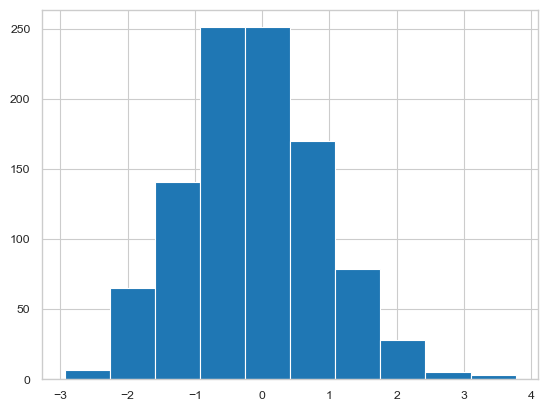

In [17]:
plt.hist(fn_normalized_rbb_samples)

<Axes: ylabel='Density'>

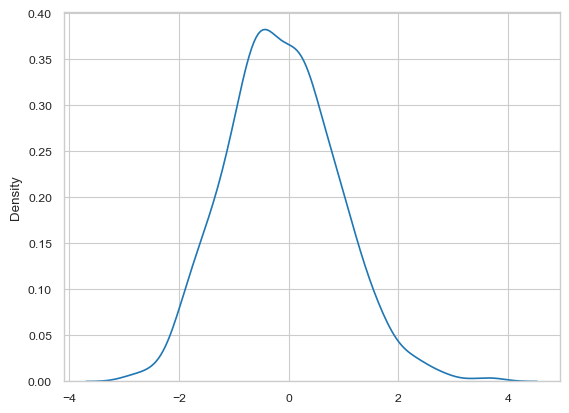

In [18]:
sns.kdeplot(fn_normalized_rbb_samples)

In [19]:
sizes = np.round(np.logspace(2, 6, 15)).astype(int)

In [20]:
sizes

array([    100,     193,     373,     720,    1389,    2683,    5179,
         10000,   19307,   37276,   71969,  138950,  268270,  517947,
       1000000])

In [21]:
data_1 = list()
for n_steps in sizes:
    print(n_steps)
    random_seed+=1
    data_1.append(get_coverage_probability_ssrw(n_steps=n_steps, fn=inverse_square, n_reps=n_reps, n_bootstraps=n_bootstraps, true_mean=true_mean, random_seed=random_seed, confidence_level=0.95)) 

100
The coverage probability for the RBB is 0.535. The average length is 2.6676730339462797
The coverage probability for the regeneration based bootstrap is 0.479. The average length is 2.5636951437084696
The coverage probability using the IID data is 0.57. The average length is 3.157254975066679
193
The coverage probability for the RBB is 0.602. The average length is 2.784575021731485
The coverage probability for the regeneration based bootstrap is 0.559. The average length is 2.6927492209062667
The coverage probability using the IID data is 0.63. The average length is 3.1992728075580943
373
The coverage probability for the RBB is 0.662. The average length is 2.748410315512651
The coverage probability for the regeneration based bootstrap is 0.608. The average length is 2.6947058432799174
The coverage probability using the IID data is 0.688. The average length is 3.090608920320609
720
The coverage probability for the RBB is 0.68. The average length is 2.7196886214692997
The coverage pr

In [22]:
rbb_cov_probs = [x[0]['cov_prob'] for x in data_1]
regeneration_based_cov_probs = [x[1]['cov_prob'] for x in data_1]
iid_cov_probs = [x[2]['cov_prob'] for x in data_1]

In [23]:
rbb_cov_interval_length = [x[0]['avg_length'] for x in data_1]
regeneration_based_cov_interval_length = [x[1]['avg_length'] for x in data_1]
iid_cov_interval_length = [x[2]['avg_length'] for x in data_1]

In [24]:
sizes

array([    100,     193,     373,     720,    1389,    2683,    5179,
         10000,   19307,   37276,   71969,  138950,  268270,  517947,
       1000000])

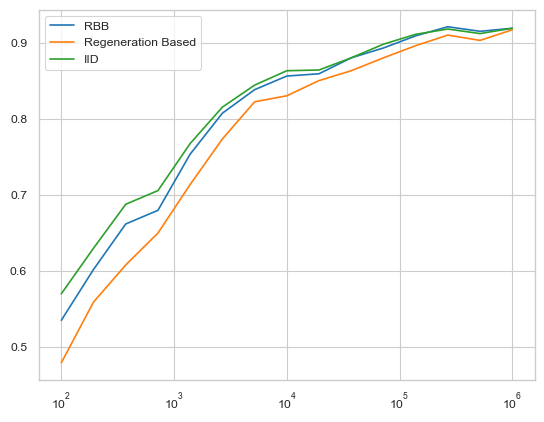

In [25]:
plt.plot(sizes, rbb_cov_probs, label='RBB')
plt.plot(sizes, regeneration_based_cov_probs, label='Regeneration Based')
plt.plot(sizes, iid_cov_probs, label='IID')
plt.xscale('log')
plt.legend()
plt.show()

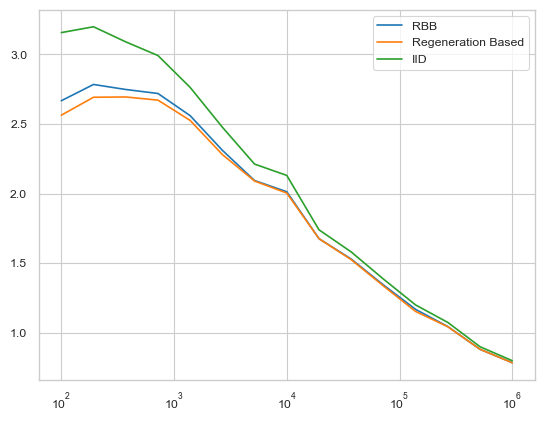

In [28]:
plt.plot(sizes, rbb_cov_interval_length, label='RBB')
plt.plot(sizes, regeneration_based_cov_interval_length, label='Regeneration Based')
plt.plot(sizes, iid_cov_interval_length, label='IID')
plt.xscale('log')
plt.legend()
plt.show()